In [1]:
from pathlib import Path
from src.visualization.render_mp4 import mp4_from_pickle_jupyter, unpickle_data
from src.common.files import get_raw_paths
import random
from tqdm import tqdm

In [3]:
paths = get_raw_paths(
    environment="sim",
    demo_source="augmentation",
    demo_outcome="success",
    task="one_leg",
    randomness="low",
)

random.shuffle(paths)

len(paths), paths[:3]

Found the following paths:
    /data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/one_leg/augmentation/low/success/*.pkl*


(242,
 [PosixPath('/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/one_leg/augmentation/low/success/2024-02-12T16:29:14.pkl.xz'),
  PosixPath('/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/one_leg/augmentation/low/success/2024-02-12T17:10:32.pkl.xz'),
  PosixPath('/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/one_leg/augmentation/low/success/2024-02-12T16:09:26.pkl.xz')])

In [4]:
for p in tqdm(paths):
    path = Path(p)
    try:
        data = unpickle_data(path)
    except EOFError:
        print(f"Failed to load {path}")

100%|██████████| 242/242 [00:21<00:00, 11.02it/s]


In [ ]:
for path in paths[:5]:
    mp4_from_pickle_jupyter(path, filename=path.stem + ".mp4", fps=20)

## Look at state-space coverage

### Load in the data

In [11]:
import zarr
import matplotlib.pyplot as plt
import numpy as np


from src.common.files import get_processed_paths

In [12]:
aug_path, teleop_path = sorted(
    get_processed_paths(
        environment="sim",
        demo_source=["teleop", "augmentation"],
        demo_outcome="success",
        task="one_leg",
        randomness="low",
    )
)

aug_path, teleop_path

Found the following paths:
    /data/scratch/ankile/furniture-data/processed/sim/one_leg/teleop/low/success.zarr
    /data/scratch/ankile/furniture-data/processed/sim/one_leg/augmentation/low/success.zarr


(PosixPath('/data/scratch/ankile/furniture-data/processed/sim/one_leg/augmentation/low/success.zarr'),
 PosixPath('/data/scratch/ankile/furniture-data/processed/sim/one_leg/teleop/low/success.zarr'))

In [13]:
z_aug = zarr.open(str(aug_path), mode="r")
z_teleop = zarr.open(str(teleop_path), mode="r")

ends_aug = z_aug["episode_ends"][:]
ends_teleop = z_teleop["episode_ends"][:]

pos_teleop = z_teleop["robot_state"][:, :3]
pos_aug = z_aug["robot_state"][:, :3]

# Split the data into episodes
pos_teleop = np.split(pos_teleop, ends_teleop[:-1])
pos_aug = np.split(pos_aug, ends_aug[:-1])

# Get the skill labels for the teleop data and split them into episodes
skill_teleop = z_teleop["skill"][:]
skill_teleop = np.split(skill_teleop, ends_teleop[:-1])

# For the teleop data, we slice off the data after the insertion
pos_teleop = [
    ep[: np.where(skill == 1)[0][3] + 1] for ep, skill in zip(pos_teleop, skill_teleop)
]

# # Concat them together again
pos_teleop = np.concatenate(pos_teleop)
pos_aug = np.concatenate(pos_aug)

In [14]:
len(skill_teleop), len(pos_teleop), len(pos_aug)

(50, 16126, 13939)

### Plot the state-space coverage in 3D

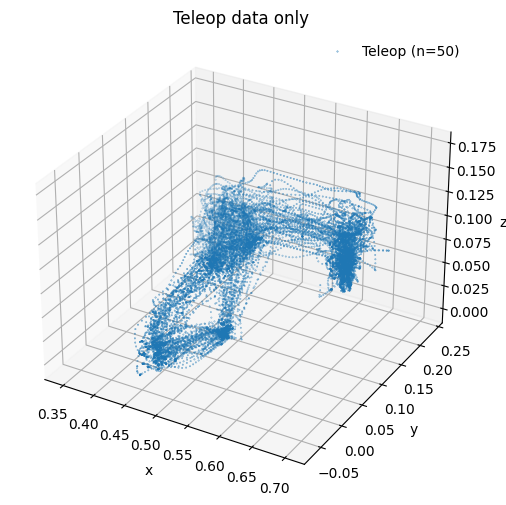

In [15]:
fig = plt.figure(figsize=(6, 6))

# Add a subplot for teleop data in the left side of the figure
ax1 = fig.add_subplot(
    111, projection="3d"
)  # Changed from 111 to 121 for a 1x2 grid, first position
ax1.scatter(*pos_teleop.T, label=f"Teleop (n={len(ends_teleop)})", s=0.1)
ax1.legend(frameon=False)
ax1.set_title("Teleop data only")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")

# # Add a subplot for augmentation data in the right side of the figure
# ax2 = fig.add_subplot(
#     122, projection="3d"
# )  # Changed from 111 to 122 for a 1x2 grid, second position
# ax2.scatter(*pos_teleop.T, label=f"Teleop (n={len(ends_teleop)})", s=0.2, alpha=0.5)
# ax2.scatter(*pos_aug.T, label=f"Augmentation (n={len(ends_aug)})", s=0.2, alpha=0.5)
# ax2.legend(frameon=False)
# ax2.set_title("Teleop and augmentation data")
# ax2.set_xlabel("x")
# ax2.set_ylabel("y")
# ax2.set_zlabel("z")

# # Title for the whole figure
# fig.suptitle(
#     "Teleop and augmentation data for `one_leg` task for V2 of augmentation system (Feb. 14, 2024)"
# )

plt.show()

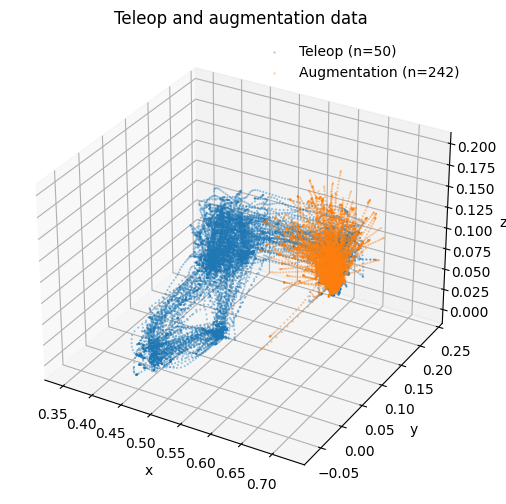

In [15]:
fig = plt.figure(figsize=(6, 6))

# Add a subplot for augmentation data in the right side of the figure
ax2 = fig.add_subplot(
    111, projection="3d"
)  # Changed from 111 to 122 for a 1x2 grid, second position
ax2.scatter(*pos_teleop.T, label=f"Teleop (n={len(ends_teleop)})", s=0.2, alpha=0.5)
ax2.scatter(*pos_aug.T, label=f"Augmentation (n={len(ends_aug)})", s=0.2, alpha=0.5)
ax2.legend(frameon=False)
ax2.set_title("Teleop and augmentation data")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")

plt.savefig("teleop_augmentation.pdf")

plt.show()

## Analyze the `round_table` augmentation

### Qualitatively analyze trajectories

In [18]:
from pathlib import Path
from src.visualization.render_mp4 import mp4_from_pickle_jupyter, unpickle_data, pickle_data
from src.common.files import get_raw_paths
import random
from tqdm import tqdm

In [6]:
paths = get_raw_paths(
    environment="sim",
    demo_source="augmentation",
    demo_outcome="success",
    task="round_table",
    randomness="low",
)

random.shuffle(paths)

len(paths), paths[:3]

Found the following paths:
    /data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/round_table/augmentation/low/success/*.pkl*


(500,
 [PosixPath('/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/round_table/augmentation/low/success/2024-02-17T21:55:36.pkl.xz'),
  PosixPath('/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/round_table/augmentation/low/success/2024-02-17T20:38:23.pkl.xz'),
  PosixPath('/data/scratch-oc40/pulkitag/ankile/furniture-data/raw/sim/round_table/augmentation/low/success/2024-02-17T21:41:00.pkl.xz')])

In [7]:
for p in tqdm(paths):
    path = Path(p)
    try:
        data = unpickle_data(path)
    except EOFError:
        print(f"Failed to load {path}")

100%|██████████| 500/500 [00:51<00:00,  9.75it/s]


In [ ]:
for path in paths[:100]:
    mp4_from_pickle_jupyter(path, filename=path.stem + ".mp4", fps=20)

### Plot coverage of new trajectories

In [1]:
import zarr
import matplotlib.pyplot as plt
import numpy as np


from src.common.files import get_processed_paths

In [2]:
aug_path, teleop_path = sorted(
    get_processed_paths(
        environment="sim",
        demo_source=["teleop", "augmentation"],
        demo_outcome="success",
        task="round_table",
        randomness="low",
    )
)

aug_path, teleop_path

Found the following paths:
    /data/scratch/ankile/furniture-data/processed/sim/round_table/teleop/low/success.zarr
    /data/scratch/ankile/furniture-data/processed/sim/round_table/augmentation/low/success.zarr


(PosixPath('/data/scratch/ankile/furniture-data/processed/sim/round_table/augmentation/low/success.zarr'),
 PosixPath('/data/scratch/ankile/furniture-data/processed/sim/round_table/teleop/low/success.zarr'))

In [3]:
z_aug = zarr.open(str(aug_path), mode="r")
z_teleop = zarr.open(str(teleop_path), mode="r")

ends_aug = z_aug["episode_ends"][:]
ends_teleop = z_teleop["episode_ends"][:]

pos_teleop = z_teleop["robot_state"][:, :3]
pos_aug = z_aug["robot_state"][:, :3]

# Split the data into episodes
pos_teleop = np.split(pos_teleop, ends_teleop[:-1])
pos_aug = np.split(pos_aug, ends_aug[:-1])

# # Get the skill labels for the teleop data and split them into episodes
# skill_teleop = z_teleop["critical"][:]
# skill_teleop = np.split(skill_teleop, ends_teleop[:-1])

# # For the teleop data, we slice off the data after the insertion
# pos_teleop = [
#     ep[: np.where(skill == 1)[0][3] + 1] for ep, skill in zip(pos_teleop, skill_teleop)
# ]

# # Concat them together again
pos_teleop = np.concatenate(pos_teleop)
pos_aug = np.concatenate(pos_aug)

In [5]:
len(ends_teleop), len(pos_teleop), len(ends_aug), len(pos_aug)

(50, 47246, 500, 28105)

### Plot the state-space coverage in 3D

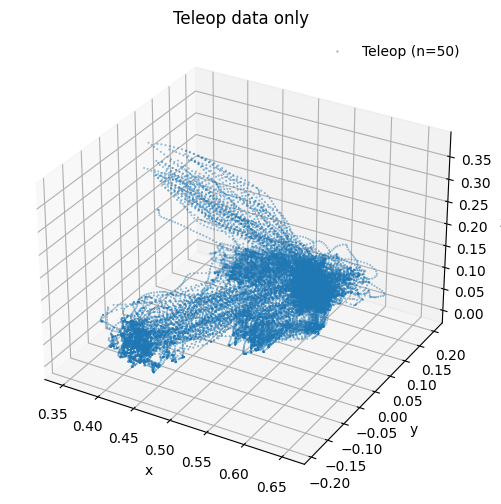

In [8]:
fig = plt.figure(figsize=(6, 6))

# Add a subplot for teleop data in the left side of the figure
ax1 = fig.add_subplot(
    111, projection="3d"
)  # Changed from 111 to 121 for a 1x2 grid, first position
ax1.scatter(*pos_teleop.T, label=f"Teleop (n={len(ends_teleop)})", s=0.1)
ax1.legend(frameon=False)
ax1.set_title("Teleop data only")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")

# # Add a subplot for augmentation data in the right side of the figure
# ax2 = fig.add_subplot(
#     122, projection="3d"
# )  # Changed from 111 to 122 for a 1x2 grid, second position
# ax2.scatter(*pos_teleop.T, label=f"Teleop (n={len(ends_teleop)})", s=0.2, alpha=0.5)
# ax2.scatter(*pos_aug.T, label=f"Augmentation (n={len(ends_aug)})", s=0.2, alpha=0.5)
# ax2.legend(frameon=False)
# ax2.set_title("Teleop and augmentation data")
# ax2.set_xlabel("x")
# ax2.set_ylabel("y")
# ax2.set_zlabel("z")

# # Title for the whole figure
# fig.suptitle(
#     "Teleop and augmentation data for `one_leg` task for V2 of augmentation system (Feb. 14, 2024)"
# )

plt.show()

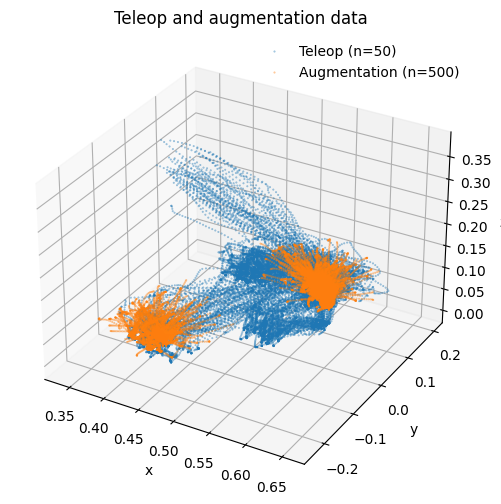

In [9]:
fig = plt.figure(figsize=(6, 6))

# Add a subplot for augmentation data in the right side of the figure
ax2 = fig.add_subplot(
    111, projection="3d"
)  # Changed from 111 to 122 for a 1x2 grid, second position
ax2.scatter(*pos_teleop.T, label=f"Teleop (n={len(ends_teleop)})", s=0.2, alpha=0.5)
ax2.scatter(*pos_aug.T, label=f"Augmentation (n={len(ends_aug)})", s=0.2, alpha=0.5)
ax2.legend(frameon=False)
ax2.set_title("Teleop and augmentation data")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")

plt.savefig("teleop_augmentation.pdf")

plt.show()

In [ ]:
|